# join Census data to geometry

This notebook joins several Census data values to Census Tract geometry, by GEOID

Reusable components include:
- opening Census data tables
- replacing Census column codes with text descriptions (from metadata file)
- choosing columns to keep
- joining data together with geometry

Possible extensions (not implemented here) include:
- fetch data directly from Census through API



## 1. load packages

In [ ]:
# Instal gdal
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,324 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
import os

In [ ]:
# set working directory

In [ ]:
##    on computer:
# dir = os.getcwd()
##
##    or in Google Colab:
# dir = '/content/drive/MyDrive/Advanced Spatial/project 1/'

## open Census Tract geometries

In [ ]:
# 2010 census tract geometries

# downloaded from Census TIGER

ct = gpd.read_file(f'{dir} + tl_2010_36_tract10/tl_2010_36_tract10.shp')

In [ ]:
# filter to NYC (by counties)

ct = ct.loc[ct['COUNTYFP10'].isin(['005','047', '061', '081', '085'])]

In [ ]:
ct.to_crs('EPSG:2263', inplace=True)

In [ ]:
ct = ct.rename(columns={'GEOID10':'GEOID'})

In [ ]:
ct = ct.set_index('GEOID')

In [ ]:
## here the canopy data gets processed and joined with census tracts (see 'tree canopy split and summarize.ipynb')

In [ ]:
# save results

#ct.to_file(f'{dir} + ct_canopy.geojson')

In [ ]:
# read results (in not in memory / if restarting notebook from this point)

# ct = gpd.read_file(f'{dir} + ct_canopy.geojson')

## join in census data

In [ ]:
# race/demographic data (table DP05 (https://data.census.gov/cedsci/table?q=dp05&tid=ACSDP1Y2019.DP05))

In [ ]:
demog_2010 = pd.read_csv(f'{dir} + ACSDP5Y2010/ACSDP5Y2010.DP05_data_with_overlays_2022-02-27T180456.csv', skiprows=[1])

In [ ]:
# slice GEOID to 10 digit code to match geometry

demog_2010['GEOID'] = demog_2010['GEO_ID'].str.slice(-11)

In [ ]:
# load labels to review

demog_2010_labels = pd.read_csv(f'{dir} + ACSDP5Y2010/ACSDP5Y2010.DP05_metadata_2022-02-27T180456.csv', header=0, names=['code','label'])

In [ ]:
demog_2010_labels[~demog_2010_labels['label'].str.contains('Margin of Error')]

,code,label
0,NAME,Geographic Area Name
1,DP05_0001E,Estimate!!SEX AND AGE!!Total population
3,DP05_0001PE,Percent!!SEX AND AGE!!Total population
5,DP05_0002E,Estimate!!SEX AND AGE!!Male
7,DP05_0002PE,Percent!!SEX AND AGE!!Male
...,...,...
315,DP05_0079PE,Percent!!HISPANIC OR LATINO AND RACE!!Not Hisp...
317,DP05_0080E,Estimate!!HISPANIC OR LATINO AND RACE!!Not His...
319,DP05_0080PE,Percent!!HISPANIC OR LATINO AND RACE!!Not Hisp...
321,DP05_0081E,Estimate!!Total housing units


In [ ]:
# choose columns to keep (include 'GEOID')

keep_columns = ['GEOID', 'DP05_0032PE', 'DP05_0033PE', 'DP05_0039PE', 'DP05_0066PE']

In [ ]:
demog_2010 = demog_2010[keep_columns]

In [ ]:
# set data types to numeric

demog_2010.iloc[:,1:] = demog_2010.iloc[:,1:].apply(pd.to_numeric, errors='coerce')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
# replace codes with text

demog_2010 = demog_2010.rename(columns = demog_2010_labels.set_index('code').to_dict()['label'])

In [ ]:
# join to census tracts

ct = ct.merge(demog_2010, on='GEOID', how='left', validate='1:1')

In [ ]:
# now housing data (table DP04 https://data.census.gov/cedsci/table?q=dp04&g=0400000US36%241400000&y=2010&tid=ACSDP5Y2010.DP04)

In [ ]:
housing_2010 = pd.read_csv(f'{dir} + ACSDP5Y2010-2/ACSDP5Y2010.DP04_data_with_overlays_2022-01-14T135352.csv', skiprows=[1])

In [ ]:
# slice GEOID to 10 digit code to match geometry

housing_2010['GEOID'] = housing_2010['GEO_ID'].str.slice(-11)

In [ ]:
# load labels to review

housing_2010_labels = pd.read_csv(f'{dir} + ACSDP5Y2010-2/ACSDP5Y2010.DP04_metadata_2022-01-14T135352.csv', header=0, names=['code','label'])

In [ ]:
housing_2010_labels[~housing_2010_labels['label'].str.contains('Margin of Error')]

,code,label
0,NAME,Geographic Area Name
1,DP04_0001E,Estimate!!HOUSING OCCUPANCY!!Total housing units
3,DP04_0001PE,Percent!!HOUSING OCCUPANCY!!Total housing units
5,DP04_0002E,Estimate!!HOUSING OCCUPANCY!!Occupied housing ...
7,DP04_0002PE,Percent!!HOUSING OCCUPANCY!!Occupied housing u...
...,...,...
555,DP04_0139PE,Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHO...
557,DP04_0140E,Estimate!!GROSS RENT AS A PERCENTAGE OF HOUSEH...
559,DP04_0140PE,Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHO...
561,DP04_0141E,Estimate!!GROSS RENT AS A PERCENTAGE OF HOUSEH...


In [ ]:
# choose columns to keep (remember to include 'GEOID')

keep_columns = ['GEOID', 'DP04_0001E', 'DP04_0007PE', 'DP04_0017PE', 'DP04_0018PE', 'DP04_0045PE', 'DP04_0046PE', 'DP04_0050PE', 'DP04_0088E', 'DP04_0132E', 'DP04_0140PE']

In [ ]:
housing_2010 = housing_2010[keep_columns]

In [ ]:
# set data types to numeric

housing_2010.iloc[:,1:] = housing_2010.iloc[:,1:].apply(pd.to_numeric, errors='coerce')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [ ]:
# replace codes with text

housing_2010 = housing_2010.rename(columns = housing_2010_labels.set_index('code').to_dict()['label'])

In [ ]:
# aggregate structures since 2000

housing_2010['Percent!!YEAR STRUCTURE BUILT!!2000 or later'] = housing_2010['Percent!!YEAR STRUCTURE BUILT!!Built 2000 to 2004'] + housing_2010['Percent!!YEAR STRUCTURE BUILT!!Built 2005 or later']

In [ ]:
housing_2010 = housing_2010.drop(['Percent!!YEAR STRUCTURE BUILT!!Built 2000 to 2004', 'Percent!!YEAR STRUCTURE BUILT!!Built 2005 or later'], axis=1)

In [ ]:
# join to census tracts

ct = ct.merge(housing_2010, on='GEOID', how='left', validate='1:1')

In [ ]:
ct.head()

,GEOID,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,no_change,gain,loss,total_2010,total_2017,percent_gain,percent_loss,total_2010_per_area,total_2017_per_area,Percent!!RACE!!One race!!White,Percent!!RACE!!One race!!Black or African American,Percent!!RACE!!One race!!Asian,Percent!!HISPANIC OR LATINO AND RACE!!Hispanic or Latino (of any race),Estimate!!HOUSING OCCUPANCY!!Total housing units,"Percent!!UNITS IN STRUCTURE!!1-unit, detached",Percent!!HOUSING TENURE!!Owner-occupied,Percent!!HOUSING TENURE!!Renter-occupied,Percent!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Moved in 2005 or later,Estimate!!VALUE!!Median (dollars),Estimate!!GROSS RENT!!Median (dollars),Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!35.0 percent or more,Percent!!YEAR STRUCTURE BUILT!!2000 or later
0,36085001700,36,085,001700,17,Census Tract 17,G5020,S,303568,0,+40.6343907,-074.0812548,"POLYGON ((960635.286 170522.891, 960814.558 17...",1.255777e+06,271162.125001,210827.749994,1.466605e+06,1.526939e+06,0.184891,0.143752,4.831224,5.029975,60.9,14.4,12.8,43.3,634,22.7,49.8,50.2,25.5,466900.0,965.0,36.7,0.0
1,36085000600,36,085,000600,6,Census Tract 6,G5020,S,1046778,1757917,+40.6181527,-074.0626420,"POLYGON ((970625.060 163279.350, 970895.163 16...",1.339095e+06,400512.249999,288974.761428,1.628070e+06,1.739607e+06,0.246004,0.177495,1.555315,1.661868,80.3,11.3,5.9,22.9,1376,14.1,40.8,59.2,38.3,386100.0,761.0,33.3,7.2
2,36085000700,36,085,000700,7,Census Tract 7,G5020,S,632261,532954,+40.6473695,-074.0782043,"POLYGON ((958928.110 175899.531, 959114.429 17...",1.328818e+06,359249.124990,255164.999997,1.583983e+06,1.688067e+06,0.226801,0.161091,2.505267,2.669889,23.1,52.4,3.1,28.7,2511,2.4,17.0,83.0,34.8,168700.0,919.0,33.0,2.5
3,36085001800,36,085,001800,18,Census Tract 18,G5020,S,1043953,1313874,+40.6019091,-074.0537589,"POLYGON ((971385.948 158871.320, 969011.332 15...",2.516473e+06,621947.875003,244040.625001,2.760513e+06,3.138420e+06,0.225302,0.088404,2.644289,3.006285,79.8,9.2,1.1,31.0,419,8.4,0.0,100.0,65.8,NaN,1238.0,28.7,0.0
4,36085000300,36,085,000300,3,Census Tract 3,G5020,S,584130,1917454,+40.6446304,-074.0719887,"POLYGON ((968643.209 171786.476, 965001.889 17...",2.701567e+05,157069.125001,121809.375001,3.919661e+05,4.272259e+05,0.400721,0.310765,0.671025,0.731388,54.4,13.5,26.6,21.4,991,0.5,36.9,63.1,32.7,345800.0,1055.0,41.4,2.3


In [ ]:
# now income (table S19013 https://data.census.gov/cedsci/table?q=median%20income&g=0400000US36%241400000&y=2010&tid=ACSDT5Y2010.B19013)

In [ ]:
income_2010 = pd.read_csv(f'{dir} + ACSDT5Y2010/ACSDT5Y2010.B19013_data_with_overlays_2022-02-28T124632.csv', skiprows=[1])

In [ ]:
# slice GEOID to 10 digit code to match geometry

income_2010['GEOID'] = income_2010['GEO_ID'].str.slice(-11)

In [ ]:
# load labels to review

income_2010_labels = pd.read_csv(f'{dir} + ACSDT5Y2010/ACSDT5Y2010.B19013_metadata_2022-02-28T124632.csv', header=0, names=['code','label'])

In [ ]:
income_2010_labels[~income_2010_labels['label'].str.contains('Margin of Error')]

,code,label
0,NAME,Geographic Area Name
1,B19013_001E,Estimate!!Median household income in the past ...


In [ ]:
# choose columns to keep (remember to include 'GEOID')

keep_columns = ['GEOID', 'B19013_001E']

In [ ]:
income_2010 = income_2010[keep_columns]

In [ ]:
# set data types to numeric

income_2010.iloc[:,1:] = income_2010.iloc[:,1:].apply(pd.to_numeric, errors='coerce')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
# replace codes with text

income_2010 = income_2010.rename(columns = income_2010_labels.set_index('code').to_dict()['label'])

In [ ]:
# join to census tracts

ct = ct.merge(income_2010, on='GEOID', how='left', validate='1:1')

In [ ]:
# save file

ct.to_file(f'{dir} + ct_canopy_2010_geom.geojson')

In [ ]:
ct.dtypes

GEOID                                                                                             object
STATEFP10                                                                                         object
COUNTYFP10                                                                                        object
TRACTCE10                                                                                         object
NAME10                                                                                            object
NAMELSAD10                                                                                        object
MTFCC10                                                                                           object
FUNCSTAT10                                                                                        object
ALAND10                                                                                            int64
AWATER10                                               

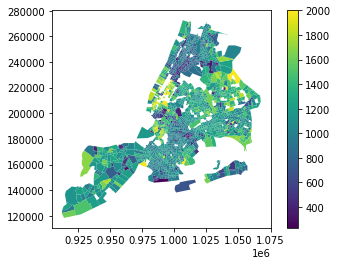

In [ ]:
# test plot

ct.plot(column='Estimate!!GROSS RENT!!Median (dollars)', legend=True)

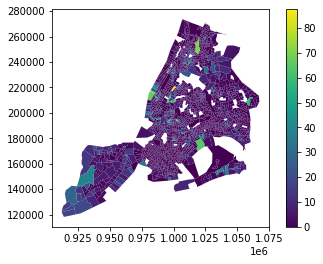

In [ ]:
ct.plot(column='Percent!!YEAR STRUCTURE BUILT!!2000 or later', legend=True)